#### 分析数据集车辆行为分布

In [1]:
import math
import os

import numpy as np
import torch
from dataset.womd import WaymoMotionDataset
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
DYNAMIC_THRESHOLD = 5.0
SIDE_DISTANCE = 0.2  # 车辆侧方允许间隙(m)
TIME_INTERVAL = 0.1  # 时间间隔(s)

In [4]:
dataset = WaymoMotionDataset(
    root="/root/ads-test/data/womd_processed",
    split="val",
    data_len=10000,
)

In [5]:
rel_dis_array = np.arange(0, 125.1, 0.5)
self_vel_array = np.arange(0, 25.1, 0.5)
back_self_vel_array = np.arange(0, 25.1, 0.5)
rel_vel_array = np.arange(-20, 20.1, 0.5)
acc_array = np.arange(-5, 5, 0.1)
pdf = np.zeros(
    (len(rel_dis_array), len(self_vel_array), len(rel_vel_array), len(acc_array))
)
flag = False
for data in tqdm(dataset):
    if (data["roadgraph_points"]["type"] == 1).sum() > 0:
        # freeway
        continue
    agent = data["agent"]
    xy = agent["xyz"][..., :2].numpy()
    heading = agent["heading"].squeeze(-1).numpy()
    shape = agent["shape"][..., :2].numpy()
    mask = (
        agent["valid"].squeeze(-1).all(dim=-1).numpy()
        & (np.linalg.norm(xy.max(axis=1) - xy.min(axis=1), axis=-1) > DYNAMIC_THRESHOLD)
        & (data["agent"]["type"] == 1).numpy()
    )
    xy = xy[mask]
    vel = np.zeros_like(xy)
    vel[:, 1:-1] = (xy[:, 2:] - xy[:, :-2]) / (2 * TIME_INTERVAL)
    vel[:, 0] = (xy[:, 1] - xy[:, 0]) / TIME_INTERVAL
    vel[:, -1] = (xy[:, -1] - xy[:, -2]) / TIME_INTERVAL
    heading = heading[mask]
    shape = shape[mask]
    for t in range(1, xy.shape[1]):
        xy_t = xy[:, t]
        for i in range(xy_t.shape[0]):
            self_xy = xy_t[i]
            # compute relative distance to other agents
            rel_dis_xy = xy_t - self_xy
            rel_x, rel_y = rel_dis_xy[:, 0], rel_dis_xy[:, 1]
            # project to axis with self agent at origin and heading as y axis
            self_heading = heading[i][t]
            new_rel_x = rel_x * np.cos(math.pi / 2 - self_heading) - rel_y * np.sin(
                math.pi / 2 - self_heading
            )
            new_rel_y = rel_x * np.sin(math.pi / 2 - self_heading) + rel_y * np.cos(
                math.pi / 2 - self_heading
            )
            # find nearest front car
            front_v_index = -1
            min_dis = 1e6
            for j in range(new_rel_x.shape[0]):
                if j == i:
                    continue
                heading_j = heading[j][t]
                if np.abs(heading_j - self_heading) > math.pi / 4:
                    continue
                width_j, width_self = shape[j][t][1], shape[i][t][1]
                if not np.abs(new_rel_x[j]) < (
                    SIDE_DISTANCE + (width_j + width_self) / 2
                ):
                    continue
                if new_rel_y[j] < min_dis:
                    min_dis = np.min([min_dis, new_rel_y[j]])
                    front_v_index = j
            if front_v_index == -1 or min_dis < 0:
                continue
            # write features to pdf array
            rel_dis = min_dis - shape[front_v_index][t][0] / 2 - shape[i][t][0] / 2
            if rel_dis > rel_dis_array[-1] or rel_dis < rel_dis_array[0]:
                continue
            self_vel = np.linalg.norm(vel[i][t])
            self_acc = (
                np.linalg.norm(vel[i][t]) - np.linalg.norm(vel[i][t - 1])
            ) / TIME_INTERVAL
            if self_acc > acc_array[-1] or self_acc < acc_array[0]:
                continue
            if self_vel < self_vel_array[1] and self_acc < 0.1:
                # pause car
                continue
            # if self_acc > 10 or self_acc < -10:
            #     flag = True
            #     break
            rel_vel = np.linalg.norm(vel[front_v_index][t]) - self_vel
            rel_dis_index = np.argmin(np.abs(rel_dis_array - rel_dis))
            self_vel_index = np.argmin(np.abs(self_vel_array - self_vel))
            self_acc_index = np.argmin(np.abs(acc_array - self_acc))
            rel_vel_index = np.argmin(np.abs(rel_vel_array - rel_vel))
            pdf[rel_dis_index, self_vel_index, rel_vel_index, self_acc_index] += 1
        if flag:
            break
    if flag:
        break

  0%|          | 0/4941 [00:00<?, ?it/s]

100%|██████████| 4941/4941 [05:38<00:00, 14.61it/s]


In [6]:
with open("gen/waymo_joint_pdf.npy", "wb") as f:
    np.save(f, pdf)

### plot

In [7]:
cf_joint_pdf = pdf
all = np.sum(cf_joint_pdf)
print(cf_joint_pdf.shape)
print(all)

(251, 51, 81, 100)
448258.0


In [8]:
acc_pdf = np.sum(cf_joint_pdf, axis=(0, 1, 2)) / all
rel_dis_pdf = np.sum(cf_joint_pdf, axis=(1, 2, 3)) / all
self_vel_pdf = np.sum(cf_joint_pdf, axis=(0, 2, 3)) / all
rel_vel_pdf = np.sum(cf_joint_pdf, axis=(0, 1, 3)) / all

In [9]:
# 计算车头时距的分布
# 先算相对距离与本车速度的联合分布
rel_dis_self_vel_joint_cnt = np.sum(cf_joint_pdf, axis=(2, 3))
# 统计车头时距
headway_array = np.arange(0, 30, 0.5)
headway_pdf = np.zeros_like(headway_array)
for i in range(rel_dis_self_vel_joint_cnt.shape[0]):
    for j in range(rel_dis_self_vel_joint_cnt.shape[1]):
        if rel_dis_self_vel_joint_cnt[i, j] == 0:
            continue
        rel_dis = rel_dis_array[i]
        self_vel = self_vel_array[j]
        if self_vel == 0:
            continue
        headway = rel_dis / self_vel
        if headway > headway_array[-1] or headway < headway_array[0]:
            continue
        headway_idx = np.argmin(np.abs(headway - headway_array))
        headway_pdf[headway_idx] += rel_dis_self_vel_joint_cnt[i, j]
print(rel_dis_self_vel_joint_cnt.shape)
print(np.sum(rel_dis_self_vel_joint_cnt))
print(np.sum(headway_pdf))
headway_pdf /= np.sum(headway_pdf)

(251, 51)
448258.0
425824.0


Text(0, 0.5, 'Probability')

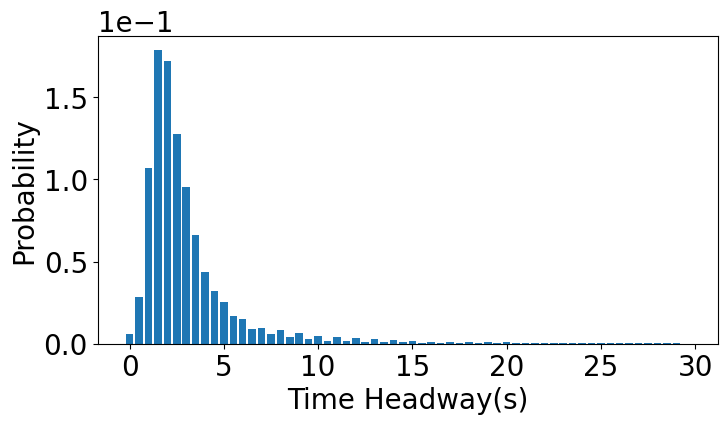

In [10]:
fontsize = 20
plt.rcParams["font.size"] = fontsize
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.bar(
    headway_array,
    headway_pdf,
    width=(30 / len(headway_array)) * 0.8,
    label="Headway PDF",
)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
ax.set_xlabel("Time Headway(s)")
ax.set_ylabel("Probability")

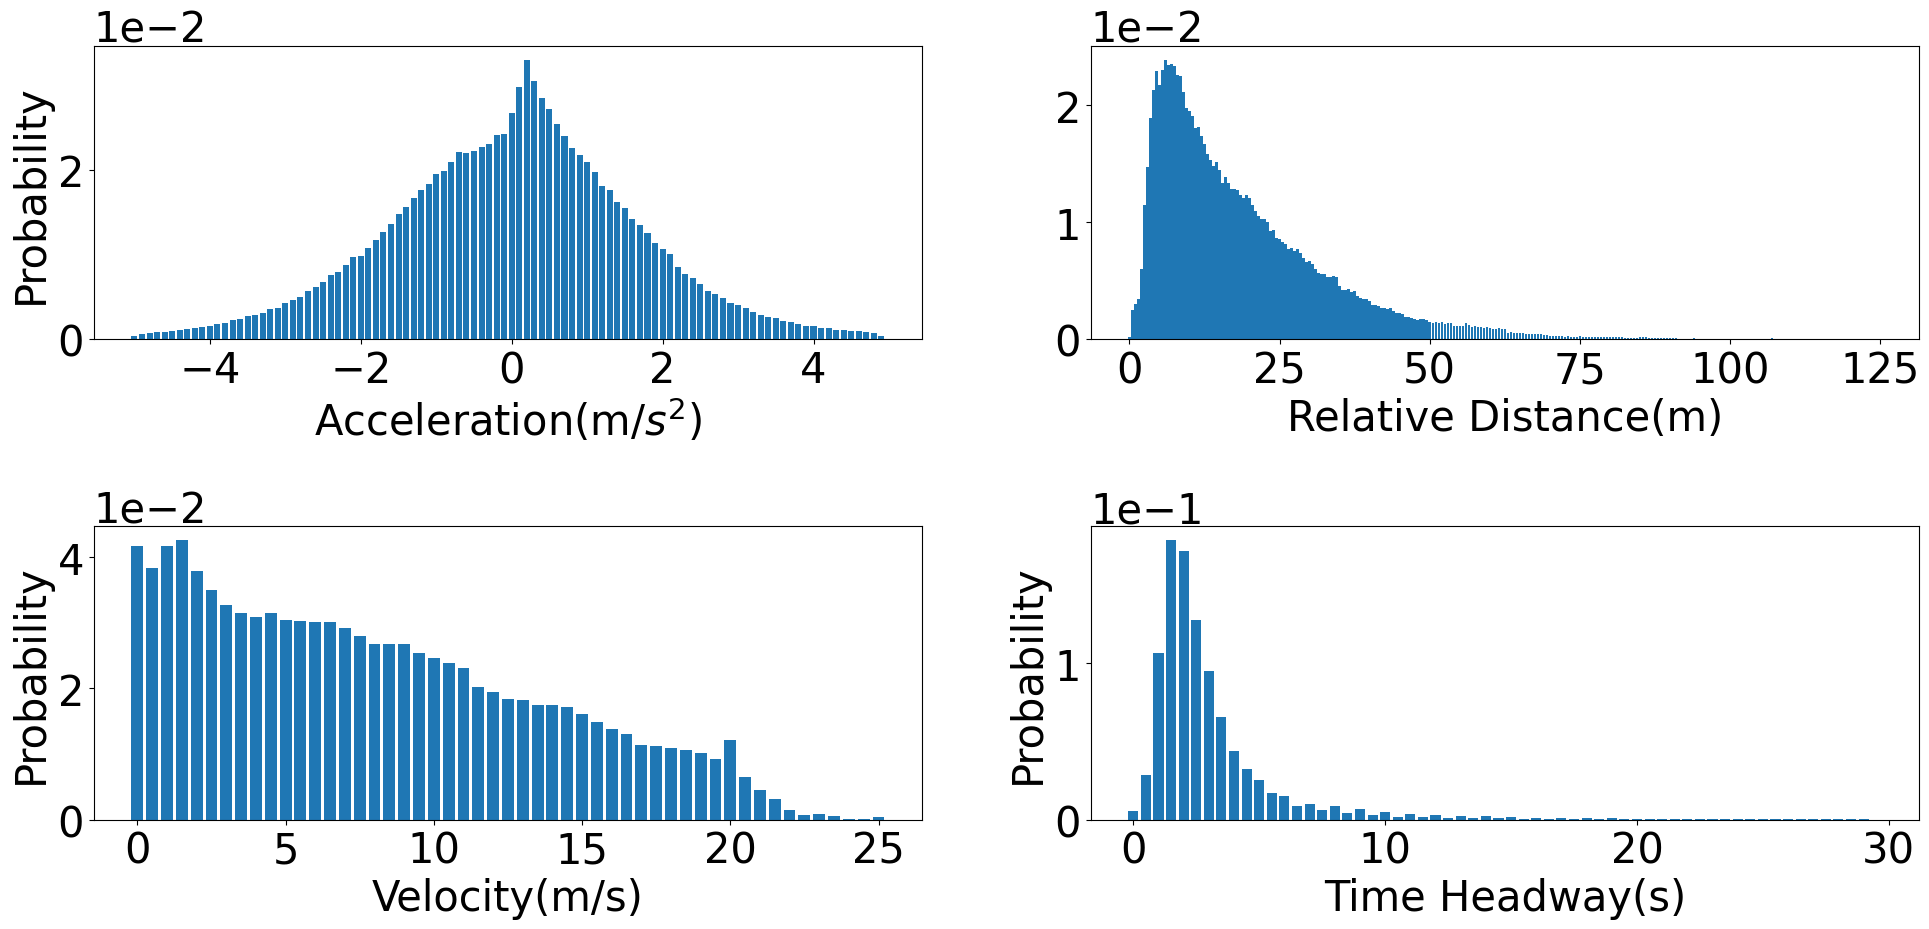

In [11]:
fontsize = 30
plt.rcParams["font.size"] = fontsize
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs[0][0].bar(acc_array, acc_pdf, width=0.08)
axs[0][0].set_xlabel("Acceleration(m/$s^2$)")
axs[0][0].set_ylabel("Probability")
axs[0][0].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

axs[1][0].bar(self_vel_array, self_vel_pdf, width=0.4)
axs[1][0].set_xlabel("Velocity(m/s)")
axs[1][0].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
axs[1][0].set_ylabel("Probability")

axs[1][1].bar(
    headway_array,
    headway_pdf,
    width=(30 / len(headway_array)) * 0.8,
    label="Headway PDF",
)
axs[1][1].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
axs[1][1].set_xlabel("Time Headway(s)")
axs[1][1].set_ylabel("Probability")

axs[0][1].bar(rel_dis_array, rel_dis_pdf, width=0.4)
axs[0][1].set_xlabel("Relative Distance(m)")
axs[0][1].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

# axs[1][1].bar(rel_vel_array, rel_vel_pdf, width=0.4)
# axs[1][1].set_xlabel("Relative Velocity(m/s)")
# axs[1][1].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
fig.tight_layout()
fig.show()

In [15]:
# 对比waymo与商汤数据的差异
cf_joint_pdf = np.load("gen/waymo_joint_pdf.npy")
all = np.sum(cf_joint_pdf)
print(cf_joint_pdf.shape)
acc_pdf = np.sum(cf_joint_pdf, axis=(0, 1, 2)) / all
rel_dis_pdf = np.sum(cf_joint_pdf, axis=(1, 2, 3)) / all
self_vel_pdf = np.sum(cf_joint_pdf, axis=(0, 2, 3)) / all
rel_vel_pdf = np.sum(cf_joint_pdf, axis=(0, 1, 3)) / all
cf_back_joint_pdf = np.load("gen/cf_back_joint_pdf_124_0711.npy")
all = np.sum(cf_back_joint_pdf)
print(cf_back_joint_pdf.shape)
back_acc_pdf = np.sum(cf_back_joint_pdf, axis=(0, 1, 2)) / all
back_rel_dis_pdf = np.sum(cf_back_joint_pdf, axis=(1, 2, 3)) / all
back_self_vel_pdf = np.sum(cf_back_joint_pdf, axis=(0, 2, 3)) / all
back_rel_vel_pdf = np.sum(cf_back_joint_pdf, axis=(0, 1, 3)) / all

(251, 51, 81, 100)
(251, 51, 81, 81)


In [25]:
# 计算车头时距的分布
headway_array = np.arange(0, 20, 0.5)
rel_dis_self_vel_joint_cnt = np.sum(cf_joint_pdf, axis=(2, 3))
headway_pdf = np.zeros_like(headway_array)
for i in range(rel_dis_self_vel_joint_cnt.shape[0]):
    for j in range(rel_dis_self_vel_joint_cnt.shape[1]):
        if rel_dis_self_vel_joint_cnt[i, j] == 0:
            continue
        rel_dis = rel_dis_array[i]
        self_vel = back_self_vel_array[j]
        if self_vel == 0:
            continue
        headway = rel_dis / self_vel
        if headway > headway_array[-1] or headway < headway_array[0]:
            continue
        headway_idx = np.argmin(np.abs(headway - headway_array))
        headway_pdf[headway_idx] += rel_dis_self_vel_joint_cnt[i, j]
print(rel_dis_self_vel_joint_cnt.shape)
print(np.sum(rel_dis_self_vel_joint_cnt))
print(np.sum(headway_pdf))
headway_pdf /= np.sum(headway_pdf)

rel_dis_self_vel_joint_cnt = np.sum(cf_back_joint_pdf, axis=(2, 3))
back_headway_pdf = np.zeros_like(headway_array)
for i in range(rel_dis_self_vel_joint_cnt.shape[0]):
    for j in range(rel_dis_self_vel_joint_cnt.shape[1]):
        if rel_dis_self_vel_joint_cnt[i, j] == 0:
            continue
        rel_dis = rel_dis_array[i]
        self_vel = back_self_vel_array[j]
        if self_vel == 0:
            continue
        headway = rel_dis / self_vel
        if headway > headway_array[-1] or headway < headway_array[0]:
            continue
        headway_idx = np.argmin(np.abs(headway - headway_array))
        back_headway_pdf[headway_idx] += rel_dis_self_vel_joint_cnt[i, j]
print(rel_dis_self_vel_joint_cnt.shape)
print(np.sum(rel_dis_self_vel_joint_cnt))
print(np.sum(back_headway_pdf))
back_headway_pdf /= np.sum(back_headway_pdf)

(251, 51)
448258.0
422613.0
(251, 51)
2349141.0
2285895.0


In [53]:
import matplotlib.ticker as ticker

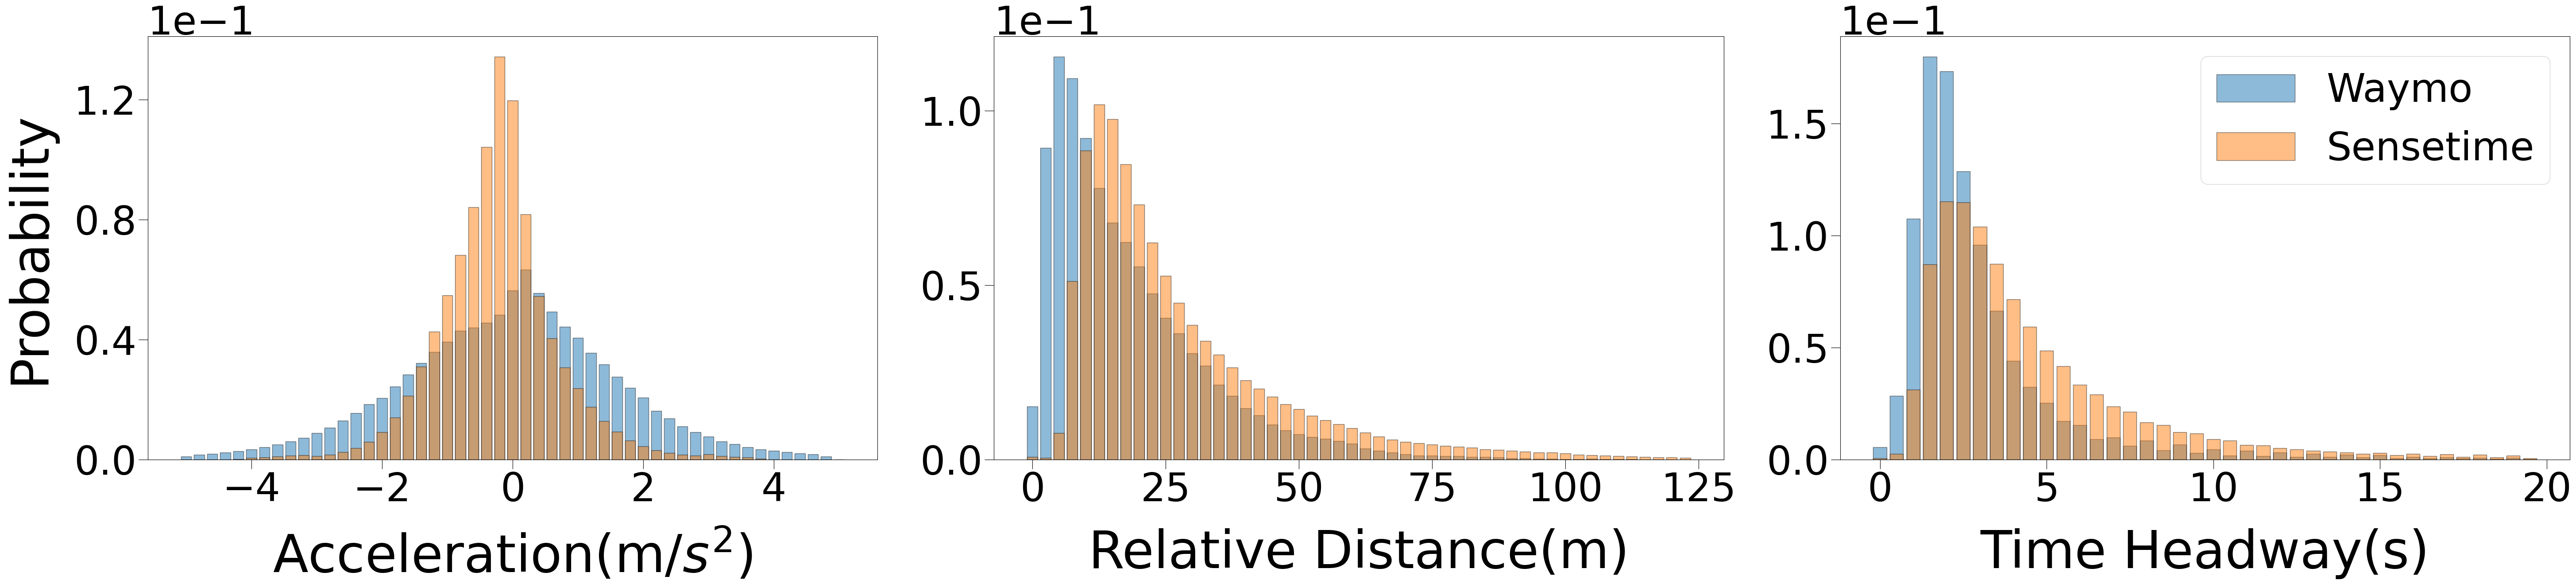

In [97]:
fontsize = 64
plt.rcParams["font.size"] = fontsize
labelpad = 30
label_fontsize = 84

fig, axs = plt.subplots(1, 3, figsize=(60, 15))

ax = axs[0]
# 统一坐标轴
back_acc_pdf1 = np.zeros_like(acc_pdf)
length_diff = len(acc_array) - len(back_acc_pdf)
back_acc_pdf1[length_diff // 2 : -length_diff // 2] = back_acc_pdf
# 调整分辨率
resolution = 0.2
acc_x = np.arange(-5, 5.1, resolution)
num = int(resolution / 0.1)
acc_pdf4plot = np.zeros_like(acc_x)
back_acc_pdf4plot = np.zeros_like(acc_x)
for i in range(len(acc_x)):
    acc_pdf4plot[i] = np.sum(acc_pdf[i * num : (i + 1) * num])
    back_acc_pdf4plot[i] = np.sum(back_acc_pdf1[i * num : (i + 1) * num])
ax.bar(
    acc_x,
    acc_pdf4plot,
    width=resolution * 0.8,
    label="Waymo",
    alpha=0.5,
    edgecolor="black",
)
ax.bar(
    acc_x,
    back_acc_pdf4plot,
    width=resolution * 0.8,
    label="Sensetime",
    alpha=0.5,
    edgecolor="black",
)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
ax.set_xlabel("Acceleration(m/$s^2$)", labelpad=labelpad, fontsize=label_fontsize)
ax.set_ylabel("Probability", fontsize=label_fontsize, labelpad=labelpad)
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
ax.tick_params(which="major", length=15)
# ax.legend()

ax = axs[1]
# 把分辨率调低一点
resolution = 2.5
rel_dis_x = np.arange(0, 125, resolution)
num = int(resolution / 0.5)
rel_dis_pdf4plot = np.zeros_like(rel_dis_x)
back_rel_dis_pdf4plot = np.zeros_like(rel_dis_x)
for i in range(len(rel_dis_x)):
    rel_dis_pdf4plot[i] = np.sum(rel_dis_pdf[i * num : (i + 1) * num])
    back_rel_dis_pdf4plot[i] = np.sum(back_rel_dis_pdf[i * num : (i + 1) * num])
ax.bar(
    rel_dis_x,
    rel_dis_pdf4plot,
    width=resolution * 0.8,
    label="Waymo",
    alpha=0.5,
    edgecolor="black",
)
ax.bar(
    rel_dis_x,
    back_rel_dis_pdf4plot,
    width=resolution * 0.8,
    label="Sensetime",
    alpha=0.5,
    edgecolor="black",
)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
ax.set_xlabel("Relative Distance(m)", labelpad=labelpad, fontsize=label_fontsize)
# 限制y轴坐标个数
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
ax.tick_params(which="major", length=15)

ax = axs[2]
ax.bar(
    headway_array, headway_pdf, width=0.4, label="Waymo", alpha=0.5, edgecolor="black"
)
ax.bar(
    headway_array,
    back_headway_pdf,
    width=0.4,
    label="Sensetime",
    alpha=0.5,
    edgecolor="black",
)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
ax.set_xlabel("Time Headway(s)", labelpad=30, fontsize=label_fontsize)
ax.tick_params(which="major", length=15)

ax.legend()

fig.tight_layout()
fig.show()

fig.savefig("gen/waymo_sensetime_diff.pdf")